In [11]:
import torch
import numpy as np
from tqdm import tqdm
from model import BendrEncoder
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from utils.data_processing import load_data_dict, get_data
from conf.eeg_channel_picks import hackathon
from conf.eeg_channel_order import standard_19_channel
from conf.eeg_annotations import braincapture_annotations, tuh_eeg_artefact_annotations

In [12]:
encoder = BendrEncoder()
encoder.load_state_dict(torch.load("encoder.pt"))

<All keys matched successfully>

In [13]:
BC_path = "/mnt/c/Users/anders/Downloads/hackathon 01/BC Bhutan/v4.0/"
TUAR_path = "/mnt/c/Users/anders/Downloads/hackathon 01/TUAR/01_tcp_ar/"

In [14]:
#data_dict = load_data_dict(data_folder_path=BC_path, channel_picks=hackathon, channel_order=standard_19_channel, annotation_dict=braincapture_annotations, tmin=0, tlen=5, labels=True)
#all_subjects = list(data_dict.keys())
#X_BC, y_BC = get_data(data_dict, all_subjects)
X_BC = torch.load("X_BC.pt")
y_BC = torch.load("y_BC.pt")

In [15]:
X_BC = torch.Tensor(X_BC)
y_BC = torch.Tensor(y_BC)

In [16]:
latent = np.empty((X_BC.shape[0], 512, 14))
batch_size = 4

for i in tqdm(range(0, X_BC.shape[0], batch_size)):
    latent[i:i+batch_size] = encoder(X_BC[i:i+batch_size]).detach().numpy()
latent = latent.reshape((latent.shape[0], -1))

100%|██████████| 208/208 [00:05<00:00, 38.19it/s]


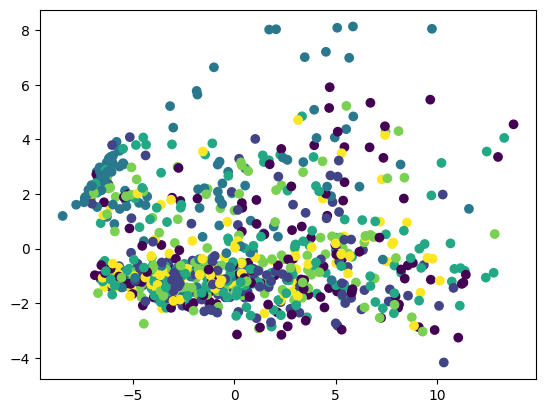

In [17]:
# Run PCA on latent
pca = PCA(n_components=30)
pca = pca.fit(latent)
latent_pca = pca.transform(latent)

fig, ax = plt.subplots()
ax.scatter(latent_pca[:, 0], latent_pca[:, 1], c = y_BC)
plt.show()

In [8]:
from model.model import LinearHeadBENDR

In [9]:
from torch import nn
from model.model import Flatten

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

out_features = 6
encode_augment = LinearHeadBENDR(encoder, 512, out_features)

classifier_layers = (
        [512 * 4 for i in range(1)]
    )
classifier_layers.insert(0, 3 * 512 * 4)

extended_classifier = nn.Sequential(Flatten())

for i in range(1, len(classifier_layers)):
    extended_classifier.add_module(
        "ext-classifier-{}".format(i),
        nn.Sequential(
            nn.Linear(classifier_layers[i - 1], classifier_layers[i]),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.BatchNorm1d(classifier_layers[i]),
        ),
    )

final_classifier = nn.Linear(classifier_layers[-1], out_features)
nn.init.xavier_normal_(final_classifier.weight)
final_classifier.bias.data.zero_()
clf = nn.Sequential(Flatten(), final_classifier)

model = nn.Sequential(encode_augment, extended_classifier, clf)
model = model.to(device)

/home/andersgm/anaconda3/envs/EEG@Scale/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [37]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

X_train, X_test, y_train, y_test = train_test_split(X_BC, y_BC, test_size=0.2)
    
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device).long()
y_test = y_test.to(device).long()   

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [40]:
learning_rate = 0.00001
n_epochs = 100

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.01, momentum=0.9, nesterov=True)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=learning_rate, epochs=n_epochs, steps_per_epoch=len(train_loader), pct_start=0.1, last_epoch=-1
)

In [41]:
for epoch in range(1, n_epochs + 1):
    correct = 0
    total = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}, train"):
        # Skip if the batch size is less than the batch size
        if len(batch[0]) < batch_size:
            continue            
        
        optimizer.zero_grad()
        
        data = batch[0]
        label = batch[1]
    
        data = data.to(device)
        label = label.to(device)
            
        logits = model(data)
        
        _, predicted = torch.max(logits.data, 1)

        total += label.size(0)
        correct += (predicted == label).sum().item()
        
        loss = criterion(logits, label)
        loss.backward()

        optimizer.step()
        scheduler.step()

    print(f"Epoch {epoch}, train accuracy: {100 * correct / total:2f}%")

    with torch.no_grad():
        model.eval()
        
        # Test accuracy
        correct = 0
        total = 0
        for batch in tqdm(test_loader, desc=f"Epoch {epoch}, test"):
            if len(batch[0]) < batch_size:
                continue         
            #data, label = batch["data"], batch["label"]
            data = batch[0]
            label = batch[1]
            
            data = data.to(device)
            label = label.to(device)

            logits = model(data)
            _, predicted = torch.max(logits.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

        print(f"Epoch {epoch}, test accuracy: {100 * correct / total:2f}%")        
        model.train()

Epoch 1, train: 100%|██████████| 166/166 [00:07<00:00, 23.19it/s]


Epoch 1, train accuracy: 23.493976%


Epoch 1, test: 100%|██████████| 42/42 [00:00<00:00, 105.27it/s]


Epoch 1, test accuracy: 26.219512%


Epoch 2, train: 100%|██████████| 166/166 [00:05<00:00, 31.55it/s]


Epoch 2, train accuracy: 25.150602%


Epoch 2, test: 100%|██████████| 42/42 [00:00<00:00, 209.37it/s]


Epoch 2, test accuracy: 34.756098%


Epoch 3, train: 100%|██████████| 166/166 [00:04<00:00, 34.53it/s]


Epoch 3, train accuracy: 22.590361%


Epoch 3, test: 100%|██████████| 42/42 [00:00<00:00, 206.51it/s]


Epoch 3, test accuracy: 17.682927%


Epoch 4, train: 100%|██████████| 166/166 [00:04<00:00, 34.40it/s]


Epoch 4, train accuracy: 25.301205%


Epoch 4, test: 100%|██████████| 42/42 [00:00<00:00, 178.78it/s]


Epoch 4, test accuracy: 17.073171%


Epoch 5, train: 100%|██████████| 166/166 [00:04<00:00, 34.88it/s]


Epoch 5, train accuracy: 25.000000%


Epoch 5, test: 100%|██████████| 42/42 [00:00<00:00, 116.60it/s]


Epoch 5, test accuracy: 17.682927%


Epoch 6, train: 100%|██████████| 166/166 [00:04<00:00, 33.45it/s]


Epoch 6, train accuracy: 24.246988%


Epoch 6, test: 100%|██████████| 42/42 [00:00<00:00, 202.41it/s]


Epoch 6, test accuracy: 17.682927%


Epoch 7, train: 100%|██████████| 166/166 [00:04<00:00, 33.56it/s]


Epoch 7, train accuracy: 23.493976%


Epoch 7, test: 100%|██████████| 42/42 [00:00<00:00, 172.24it/s]


Epoch 7, test accuracy: 16.463415%


Epoch 8, train: 100%|██████████| 166/166 [00:05<00:00, 32.70it/s]


Epoch 8, train accuracy: 26.656627%


Epoch 8, test: 100%|██████████| 42/42 [00:00<00:00, 65.73it/s] 


Epoch 8, test accuracy: 18.902439%


Epoch 9, train: 100%|██████████| 166/166 [00:06<00:00, 25.31it/s]


Epoch 9, train accuracy: 24.548193%


Epoch 9, test: 100%|██████████| 42/42 [00:00<00:00, 69.92it/s]


Epoch 9, test accuracy: 20.731707%


Epoch 10, train: 100%|██████████| 166/166 [00:06<00:00, 26.32it/s]


Epoch 10, train accuracy: 23.795181%


Epoch 10, test: 100%|██████████| 42/42 [00:00<00:00, 172.35it/s]


Epoch 10, test accuracy: 23.170732%


Epoch 11, train: 100%|██████████| 166/166 [00:06<00:00, 25.98it/s]


Epoch 11, train accuracy: 22.891566%


Epoch 11, test: 100%|██████████| 42/42 [00:00<00:00, 70.57it/s]


Epoch 11, test accuracy: 20.121951%


Epoch 12, train: 100%|██████████| 166/166 [00:05<00:00, 28.56it/s]


Epoch 12, train accuracy: 27.108434%


Epoch 12, test: 100%|██████████| 42/42 [00:00<00:00, 69.45it/s]


Epoch 12, test accuracy: 25.000000%


Epoch 13, train: 100%|██████████| 166/166 [00:05<00:00, 29.10it/s]


Epoch 13, train accuracy: 28.614458%


Epoch 13, test: 100%|██████████| 42/42 [00:00<00:00, 82.93it/s] 


Epoch 13, test accuracy: 17.682927%


Epoch 14, train: 100%|██████████| 166/166 [00:06<00:00, 27.50it/s]


Epoch 14, train accuracy: 27.861446%


Epoch 14, test: 100%|██████████| 42/42 [00:00<00:00, 152.59it/s]


Epoch 14, test accuracy: 18.292683%


Epoch 15, train: 100%|██████████| 166/166 [00:04<00:00, 33.68it/s]


Epoch 15, train accuracy: 30.120482%


Epoch 15, test: 100%|██████████| 42/42 [00:00<00:00, 157.70it/s]


Epoch 15, test accuracy: 26.829268%


Epoch 16, train: 100%|██████████| 166/166 [00:05<00:00, 32.14it/s]


Epoch 16, train accuracy: 30.421687%


Epoch 16, test: 100%|██████████| 42/42 [00:00<00:00, 127.73it/s]


Epoch 16, test accuracy: 20.121951%


Epoch 17, train: 100%|██████████| 166/166 [00:05<00:00, 31.94it/s]


Epoch 17, train accuracy: 31.325301%


Epoch 17, test: 100%|██████████| 42/42 [00:00<00:00, 200.34it/s]


Epoch 17, test accuracy: 28.048780%


Epoch 18, train: 100%|██████████| 166/166 [00:04<00:00, 34.69it/s]


Epoch 18, train accuracy: 31.174699%


Epoch 18, test: 100%|██████████| 42/42 [00:00<00:00, 205.11it/s]


Epoch 18, test accuracy: 32.926829%


Epoch 19, train: 100%|██████████| 166/166 [00:05<00:00, 31.73it/s]


Epoch 19, train accuracy: 34.036145%


Epoch 19, test: 100%|██████████| 42/42 [00:00<00:00, 108.19it/s]


Epoch 19, test accuracy: 37.195122%


Epoch 20, train: 100%|██████████| 166/166 [00:04<00:00, 34.61it/s]


Epoch 20, train accuracy: 37.349398%


Epoch 20, test: 100%|██████████| 42/42 [00:00<00:00, 144.07it/s]


Epoch 20, test accuracy: 28.048780%


Epoch 21, train: 100%|██████████| 166/166 [00:04<00:00, 34.14it/s]


Epoch 21, train accuracy: 32.981928%


Epoch 21, test: 100%|██████████| 42/42 [00:00<00:00, 67.68it/s]


Epoch 21, test accuracy: 29.268293%


Epoch 22, train: 100%|██████████| 166/166 [00:04<00:00, 33.86it/s]


Epoch 22, train accuracy: 36.144578%


Epoch 22, test: 100%|██████████| 42/42 [00:00<00:00, 146.81it/s]


Epoch 22, test accuracy: 35.975610%


Epoch 23, train: 100%|██████████| 166/166 [00:05<00:00, 31.54it/s]


Epoch 23, train accuracy: 36.897590%


Epoch 23, test: 100%|██████████| 42/42 [00:00<00:00, 115.14it/s]


Epoch 23, test accuracy: 32.926829%


Epoch 24, train: 100%|██████████| 166/166 [00:05<00:00, 31.78it/s]


Epoch 24, train accuracy: 37.198795%


Epoch 24, test: 100%|██████████| 42/42 [00:00<00:00, 85.08it/s]


Epoch 24, test accuracy: 37.804878%


Epoch 25, train: 100%|██████████| 166/166 [00:05<00:00, 28.10it/s]


Epoch 25, train accuracy: 38.855422%


Epoch 25, test: 100%|██████████| 42/42 [00:00<00:00, 116.85it/s]


Epoch 25, test accuracy: 33.536585%


Epoch 26, train: 100%|██████████| 166/166 [00:06<00:00, 25.60it/s]


Epoch 26, train accuracy: 37.198795%


Epoch 26, test: 100%|██████████| 42/42 [00:00<00:00, 68.44it/s]


Epoch 26, test accuracy: 35.975610%


Epoch 27, train: 100%|██████████| 166/166 [00:06<00:00, 23.83it/s]


Epoch 27, train accuracy: 42.319277%


Epoch 27, test: 100%|██████████| 42/42 [00:00<00:00, 61.31it/s]


Epoch 27, test accuracy: 33.536585%


Epoch 28, train: 100%|██████████| 166/166 [00:07<00:00, 22.70it/s]


Epoch 28, train accuracy: 34.337349%


Epoch 28, test: 100%|██████████| 42/42 [00:00<00:00, 51.96it/s]


Epoch 28, test accuracy: 29.268293%


Epoch 29, train: 100%|██████████| 166/166 [00:06<00:00, 24.72it/s]


Epoch 29, train accuracy: 38.253012%


Epoch 29, test: 100%|██████████| 42/42 [00:00<00:00, 72.74it/s]


Epoch 29, test accuracy: 33.536585%


Epoch 30, train: 100%|██████████| 166/166 [00:06<00:00, 25.81it/s]


Epoch 30, train accuracy: 38.704819%


Epoch 30, test: 100%|██████████| 42/42 [00:00<00:00, 197.91it/s]


Epoch 30, test accuracy: 26.829268%


Epoch 31, train: 100%|██████████| 166/166 [00:06<00:00, 26.63it/s]


Epoch 31, train accuracy: 36.746988%


Epoch 31, test: 100%|██████████| 42/42 [00:00<00:00, 88.60it/s] 


Epoch 31, test accuracy: 28.048780%


Epoch 32, train: 100%|██████████| 166/166 [00:06<00:00, 23.72it/s]


Epoch 32, train accuracy: 36.445783%


Epoch 32, test: 100%|██████████| 42/42 [00:00<00:00, 58.05it/s]


Epoch 32, test accuracy: 29.878049%


Epoch 33, train: 100%|██████████| 166/166 [00:06<00:00, 27.05it/s]


Epoch 33, train accuracy: 41.566265%


Epoch 33, test: 100%|██████████| 42/42 [00:00<00:00, 88.41it/s] 


Epoch 33, test accuracy: 32.926829%


Epoch 34, train: 100%|██████████| 166/166 [00:08<00:00, 20.50it/s]


Epoch 34, train accuracy: 37.650602%


Epoch 34, test: 100%|██████████| 42/42 [00:00<00:00, 43.13it/s]


Epoch 34, test accuracy: 44.512195%


Epoch 35, train: 100%|██████████| 166/166 [00:08<00:00, 18.50it/s]


Epoch 35, train accuracy: 41.716867%


Epoch 35, test: 100%|██████████| 42/42 [00:00<00:00, 50.27it/s]


Epoch 35, test accuracy: 33.536585%


Epoch 36, train: 100%|██████████| 166/166 [00:08<00:00, 19.39it/s]


Epoch 36, train accuracy: 43.373494%


Epoch 36, test: 100%|██████████| 42/42 [00:00<00:00, 86.65it/s]


Epoch 36, test accuracy: 32.317073%


Epoch 37, train: 100%|██████████| 166/166 [00:05<00:00, 31.77it/s]


Epoch 37, train accuracy: 40.963855%


Epoch 37, test: 100%|██████████| 42/42 [00:00<00:00, 202.85it/s]


Epoch 37, test accuracy: 34.146341%


Epoch 38, train: 100%|██████████| 166/166 [00:04<00:00, 34.60it/s]


Epoch 38, train accuracy: 41.566265%


Epoch 38, test: 100%|██████████| 42/42 [00:00<00:00, 205.14it/s]


Epoch 38, test accuracy: 40.243902%


Epoch 39, train: 100%|██████████| 166/166 [00:05<00:00, 29.01it/s]


Epoch 39, train accuracy: 43.524096%


Epoch 39, test: 100%|██████████| 42/42 [00:00<00:00, 64.16it/s]


Epoch 39, test accuracy: 42.682927%


Epoch 40, train: 100%|██████████| 166/166 [00:07<00:00, 22.04it/s]


Epoch 40, train accuracy: 42.469880%


Epoch 40, test: 100%|██████████| 42/42 [00:00<00:00, 44.33it/s]


Epoch 40, test accuracy: 46.341463%


Epoch 41, train: 100%|██████████| 166/166 [00:06<00:00, 25.26it/s]


Epoch 41, train accuracy: 42.921687%


Epoch 41, test: 100%|██████████| 42/42 [00:00<00:00, 64.94it/s]


Epoch 41, test accuracy: 37.804878%


Epoch 42, train: 100%|██████████| 166/166 [00:06<00:00, 24.86it/s]


Epoch 42, train accuracy: 45.632530%


Epoch 42, test: 100%|██████████| 42/42 [00:01<00:00, 38.79it/s]


Epoch 42, test accuracy: 34.146341%


Epoch 43, train: 100%|██████████| 166/166 [00:06<00:00, 24.49it/s]


Epoch 43, train accuracy: 47.289157%


Epoch 43, test: 100%|██████████| 42/42 [00:00<00:00, 80.83it/s]


Epoch 43, test accuracy: 36.585366%


Epoch 44, train: 100%|██████████| 166/166 [00:06<00:00, 24.86it/s]


Epoch 44, train accuracy: 44.728916%


Epoch 44, test: 100%|██████████| 42/42 [00:00<00:00, 42.84it/s]


Epoch 44, test accuracy: 46.341463%


Epoch 45, train: 100%|██████████| 166/166 [00:05<00:00, 27.94it/s]


Epoch 45, train accuracy: 46.234940%


Epoch 45, test: 100%|██████████| 42/42 [00:00<00:00, 63.44it/s]


Epoch 45, test accuracy: 46.341463%


Epoch 46, train: 100%|██████████| 166/166 [00:06<00:00, 26.74it/s]


Epoch 46, train accuracy: 45.180723%


Epoch 46, test: 100%|██████████| 42/42 [00:00<00:00, 57.20it/s]


Epoch 46, test accuracy: 44.512195%


Epoch 47, train: 100%|██████████| 166/166 [00:05<00:00, 30.65it/s]


Epoch 47, train accuracy: 48.343373%


Epoch 47, test: 100%|██████████| 42/42 [00:00<00:00, 146.68it/s]


Epoch 47, test accuracy: 42.682927%


Epoch 48, train: 100%|██████████| 166/166 [00:04<00:00, 33.64it/s]


Epoch 48, train accuracy: 51.054217%


Epoch 48, test: 100%|██████████| 42/42 [00:00<00:00, 141.67it/s]


Epoch 48, test accuracy: 39.634146%


Epoch 49, train: 100%|██████████| 166/166 [00:05<00:00, 31.74it/s]


Epoch 49, train accuracy: 45.331325%


Epoch 49, test: 100%|██████████| 42/42 [00:00<00:00, 63.53it/s]


Epoch 49, test accuracy: 48.170732%


Epoch 50, train: 100%|██████████| 166/166 [00:06<00:00, 26.06it/s]


Epoch 50, train accuracy: 49.849398%


Epoch 50, test: 100%|██████████| 42/42 [00:00<00:00, 83.24it/s] 


Epoch 50, test accuracy: 51.219512%


Epoch 51, train: 100%|██████████| 166/166 [00:04<00:00, 34.20it/s]


Epoch 51, train accuracy: 45.481928%


Epoch 51, test: 100%|██████████| 42/42 [00:00<00:00, 153.41it/s]


Epoch 51, test accuracy: 43.902439%


Epoch 52, train: 100%|██████████| 166/166 [00:05<00:00, 32.65it/s]


Epoch 52, train accuracy: 47.740964%


Epoch 52, test: 100%|██████████| 42/42 [00:00<00:00, 187.31it/s]


Epoch 52, test accuracy: 42.682927%


Epoch 53, train: 100%|██████████| 166/166 [00:04<00:00, 33.25it/s]


Epoch 53, train accuracy: 46.837349%


Epoch 53, test: 100%|██████████| 42/42 [00:00<00:00, 158.66it/s]


Epoch 53, test accuracy: 40.243902%


Epoch 54, train: 100%|██████████| 166/166 [00:04<00:00, 33.58it/s]


Epoch 54, train accuracy: 50.301205%


Epoch 54, test: 100%|██████████| 42/42 [00:00<00:00, 196.58it/s]


Epoch 54, test accuracy: 33.536585%


Epoch 55, train: 100%|██████████| 166/166 [00:04<00:00, 33.65it/s]


Epoch 55, train accuracy: 47.740964%


Epoch 55, test: 100%|██████████| 42/42 [00:00<00:00, 100.23it/s]


Epoch 55, test accuracy: 48.170732%


Epoch 56, train: 100%|██████████| 166/166 [00:05<00:00, 30.98it/s]


Epoch 56, train accuracy: 48.795181%


Epoch 56, test: 100%|██████████| 42/42 [00:00<00:00, 125.60it/s]


Epoch 56, test accuracy: 43.902439%


Epoch 57, train: 100%|██████████| 166/166 [00:06<00:00, 25.57it/s]


Epoch 57, train accuracy: 49.397590%


Epoch 57, test: 100%|██████████| 42/42 [00:00<00:00, 62.97it/s]


Epoch 57, test accuracy: 46.951220%


Epoch 58, train: 100%|██████████| 166/166 [00:06<00:00, 27.53it/s]


Epoch 58, train accuracy: 46.234940%


Epoch 58, test: 100%|██████████| 42/42 [00:00<00:00, 151.97it/s]


Epoch 58, test accuracy: 43.902439%


Epoch 59, train: 100%|██████████| 166/166 [00:06<00:00, 25.33it/s]


Epoch 59, train accuracy: 53.313253%


Epoch 59, test: 100%|██████████| 42/42 [00:00<00:00, 60.47it/s]


Epoch 59, test accuracy: 32.317073%


Epoch 60, train: 100%|██████████| 166/166 [00:06<00:00, 23.93it/s]


Epoch 60, train accuracy: 49.698795%


Epoch 60, test: 100%|██████████| 42/42 [00:00<00:00, 68.31it/s]


Epoch 60, test accuracy: 56.097561%


Epoch 61, train: 100%|██████████| 166/166 [00:09<00:00, 17.50it/s]


Epoch 61, train accuracy: 50.150602%


Epoch 61, test: 100%|██████████| 42/42 [00:00<00:00, 60.18it/s]


Epoch 61, test accuracy: 53.658537%


Epoch 62, train: 100%|██████████| 166/166 [00:08<00:00, 18.76it/s]


Epoch 62, train accuracy: 50.150602%


Epoch 62, test: 100%|██████████| 42/42 [00:00<00:00, 53.56it/s]


Epoch 62, test accuracy: 41.463415%


Epoch 63, train: 100%|██████████| 166/166 [00:07<00:00, 22.75it/s]


Epoch 63, train accuracy: 49.698795%


Epoch 63, test: 100%|██████████| 42/42 [00:00<00:00, 51.67it/s]


Epoch 63, test accuracy: 48.780488%


Epoch 64, train: 100%|██████████| 166/166 [00:06<00:00, 24.07it/s]


Epoch 64, train accuracy: 47.590361%


Epoch 64, test: 100%|██████████| 42/42 [00:00<00:00, 55.33it/s]


Epoch 64, test accuracy: 54.878049%


Epoch 65, train: 100%|██████████| 166/166 [00:06<00:00, 25.91it/s]


Epoch 65, train accuracy: 49.548193%


Epoch 65, test: 100%|██████████| 42/42 [00:00<00:00, 70.05it/s]


Epoch 65, test accuracy: 37.195122%


Epoch 66, train: 100%|██████████| 166/166 [00:06<00:00, 25.71it/s]


Epoch 66, train accuracy: 49.548193%


Epoch 66, test: 100%|██████████| 42/42 [00:00<00:00, 76.83it/s]


Epoch 66, test accuracy: 53.048780%


Epoch 67, train: 100%|██████████| 166/166 [00:06<00:00, 26.02it/s]


Epoch 67, train accuracy: 52.560241%


Epoch 67, test: 100%|██████████| 42/42 [00:00<00:00, 88.78it/s] 


Epoch 67, test accuracy: 47.560976%


Epoch 68, train: 100%|██████████| 166/166 [00:07<00:00, 23.03it/s]


Epoch 68, train accuracy: 49.698795%


Epoch 68, test: 100%|██████████| 42/42 [00:00<00:00, 95.04it/s] 


Epoch 68, test accuracy: 51.219512%


Epoch 69, train: 100%|██████████| 166/166 [00:07<00:00, 21.77it/s]


Epoch 69, train accuracy: 52.108434%


Epoch 69, test: 100%|██████████| 42/42 [00:00<00:00, 48.51it/s]


Epoch 69, test accuracy: 44.512195%


Epoch 70, train: 100%|██████████| 166/166 [00:05<00:00, 30.09it/s]


Epoch 70, train accuracy: 50.753012%


Epoch 70, test: 100%|██████████| 42/42 [00:00<00:00, 105.74it/s]


Epoch 70, test accuracy: 45.731707%


Epoch 71, train: 100%|██████████| 166/166 [00:05<00:00, 28.08it/s]


Epoch 71, train accuracy: 51.506024%


Epoch 71, test: 100%|██████████| 42/42 [00:00<00:00, 72.10it/s]


Epoch 71, test accuracy: 51.219512%


Epoch 72, train: 100%|██████████| 166/166 [00:06<00:00, 25.88it/s]


Epoch 72, train accuracy: 50.301205%


Epoch 72, test: 100%|██████████| 42/42 [00:00<00:00, 80.08it/s] 


Epoch 72, test accuracy: 48.170732%


Epoch 73, train: 100%|██████████| 166/166 [00:06<00:00, 27.31it/s]


Epoch 73, train accuracy: 51.807229%


Epoch 73, test: 100%|██████████| 42/42 [00:00<00:00, 92.97it/s] 


Epoch 73, test accuracy: 51.219512%


Epoch 74, train: 100%|██████████| 166/166 [00:05<00:00, 31.86it/s]


Epoch 74, train accuracy: 54.066265%


Epoch 74, test: 100%|██████████| 42/42 [00:00<00:00, 154.89it/s]


Epoch 74, test accuracy: 54.878049%


Epoch 75, train: 100%|██████████| 166/166 [00:05<00:00, 32.65it/s]


Epoch 75, train accuracy: 51.054217%


Epoch 75, test: 100%|██████████| 42/42 [00:00<00:00, 93.31it/s]


Epoch 75, test accuracy: 50.000000%


Epoch 76, train: 100%|██████████| 166/166 [00:05<00:00, 32.71it/s]


Epoch 76, train accuracy: 55.120482%


Epoch 76, test: 100%|██████████| 42/42 [00:00<00:00, 131.29it/s]


Epoch 76, test accuracy: 57.926829%


Epoch 77, train: 100%|██████████| 166/166 [00:05<00:00, 32.97it/s]


Epoch 77, train accuracy: 53.915663%


Epoch 77, test: 100%|██████████| 42/42 [00:00<00:00, 93.65it/s]


Epoch 77, test accuracy: 46.951220%


Epoch 78, train: 100%|██████████| 166/166 [00:05<00:00, 32.07it/s]


Epoch 78, train accuracy: 49.849398%


Epoch 78, test: 100%|██████████| 42/42 [00:00<00:00, 112.92it/s]


Epoch 78, test accuracy: 51.219512%


Epoch 79, train: 100%|██████████| 166/166 [00:04<00:00, 33.64it/s]


Epoch 79, train accuracy: 54.066265%


Epoch 79, test: 100%|██████████| 42/42 [00:00<00:00, 141.56it/s]


Epoch 79, test accuracy: 51.219512%


Epoch 80, train: 100%|██████████| 166/166 [00:05<00:00, 31.22it/s]


Epoch 80, train accuracy: 53.463855%


Epoch 80, test: 100%|██████████| 42/42 [00:00<00:00, 163.21it/s]


Epoch 80, test accuracy: 49.390244%


Epoch 81, train: 100%|██████████| 166/166 [00:05<00:00, 30.59it/s]


Epoch 81, train accuracy: 53.313253%


Epoch 81, test: 100%|██████████| 42/42 [00:00<00:00, 92.68it/s]


Epoch 81, test accuracy: 48.780488%


Epoch 82, train: 100%|██████████| 166/166 [00:05<00:00, 33.13it/s]


Epoch 82, train accuracy: 56.325301%


Epoch 82, test: 100%|██████████| 42/42 [00:00<00:00, 131.61it/s]


Epoch 82, test accuracy: 49.390244%


Epoch 83, train: 100%|██████████| 166/166 [00:05<00:00, 32.84it/s]


Epoch 83, train accuracy: 54.518072%


Epoch 83, test: 100%|██████████| 42/42 [00:00<00:00, 98.08it/s]


Epoch 83, test accuracy: 44.512195%


Epoch 84, train: 100%|██████████| 166/166 [00:04<00:00, 33.34it/s]


Epoch 84, train accuracy: 52.259036%


Epoch 84, test: 100%|██████████| 42/42 [00:00<00:00, 103.22it/s]


Epoch 84, test accuracy: 45.121951%


Epoch 85, train: 100%|██████████| 166/166 [00:04<00:00, 33.57it/s]


Epoch 85, train accuracy: 55.421687%


Epoch 85, test: 100%|██████████| 42/42 [00:00<00:00, 118.70it/s]


Epoch 85, test accuracy: 54.268293%


Epoch 86, train: 100%|██████████| 166/166 [00:05<00:00, 31.27it/s]


Epoch 86, train accuracy: 52.409639%


Epoch 86, test: 100%|██████████| 42/42 [00:00<00:00, 160.05it/s]


Epoch 86, test accuracy: 53.658537%


Epoch 87, train: 100%|██████████| 166/166 [00:05<00:00, 32.67it/s]


Epoch 87, train accuracy: 57.078313%


Epoch 87, test: 100%|██████████| 42/42 [00:00<00:00, 78.65it/s]


Epoch 87, test accuracy: 49.390244%


Epoch 88, train: 100%|██████████| 166/166 [00:05<00:00, 32.22it/s]


Epoch 88, train accuracy: 57.530120%


Epoch 88, test: 100%|██████████| 42/42 [00:00<00:00, 150.88it/s]


Epoch 88, test accuracy: 54.268293%


Epoch 89, train: 100%|██████████| 166/166 [00:04<00:00, 33.64it/s]


Epoch 89, train accuracy: 54.066265%


Epoch 89, test: 100%|██████████| 42/42 [00:00<00:00, 140.77it/s]


Epoch 89, test accuracy: 50.609756%


Epoch 90, train: 100%|██████████| 166/166 [00:05<00:00, 31.21it/s]


Epoch 90, train accuracy: 54.969880%


Epoch 90, test: 100%|██████████| 42/42 [00:00<00:00, 102.87it/s]


Epoch 90, test accuracy: 52.439024%


Epoch 91, train: 100%|██████████| 166/166 [00:05<00:00, 27.69it/s]


Epoch 91, train accuracy: 58.885542%


Epoch 91, test: 100%|██████████| 42/42 [00:00<00:00, 72.28it/s]


Epoch 91, test accuracy: 49.390244%


Epoch 92, train: 100%|██████████| 166/166 [00:06<00:00, 25.93it/s]


Epoch 92, train accuracy: 56.927711%


Epoch 92, test: 100%|██████████| 42/42 [00:00<00:00, 65.47it/s]


Epoch 92, test accuracy: 57.317073%


Epoch 93, train: 100%|██████████| 166/166 [00:05<00:00, 32.09it/s]


Epoch 93, train accuracy: 57.831325%


Epoch 93, test: 100%|██████████| 42/42 [00:00<00:00, 92.98it/s] 


Epoch 93, test accuracy: 46.951220%


Epoch 94, train: 100%|██████████| 166/166 [00:05<00:00, 29.99it/s]


Epoch 94, train accuracy: 56.024096%


Epoch 94, test: 100%|██████████| 42/42 [00:00<00:00, 73.26it/s]


Epoch 94, test accuracy: 54.268293%


Epoch 95, train: 100%|██████████| 166/166 [00:05<00:00, 31.11it/s]


Epoch 95, train accuracy: 55.572289%


Epoch 95, test: 100%|██████████| 42/42 [00:00<00:00, 144.18it/s]


Epoch 95, test accuracy: 46.341463%


Epoch 96, train: 100%|██████████| 166/166 [00:05<00:00, 31.04it/s]


Epoch 96, train accuracy: 56.024096%


Epoch 96, test: 100%|██████████| 42/42 [00:00<00:00, 106.10it/s]


Epoch 96, test accuracy: 56.097561%


Epoch 97, train: 100%|██████████| 166/166 [00:05<00:00, 31.03it/s]


Epoch 97, train accuracy: 56.626506%


Epoch 97, test: 100%|██████████| 42/42 [00:00<00:00, 88.71it/s] 


Epoch 97, test accuracy: 52.439024%


Epoch 98, train: 100%|██████████| 166/166 [00:05<00:00, 31.28it/s]


Epoch 98, train accuracy: 55.873494%


Epoch 98, test: 100%|██████████| 42/42 [00:00<00:00, 161.04it/s]


Epoch 98, test accuracy: 50.609756%


Epoch 99, train: 100%|██████████| 166/166 [00:05<00:00, 32.36it/s]


Epoch 99, train accuracy: 57.228916%


Epoch 99, test: 100%|██████████| 42/42 [00:00<00:00, 171.73it/s]


Epoch 99, test accuracy: 48.780488%


Epoch 100, train: 100%|██████████| 166/166 [00:05<00:00, 31.07it/s]


Epoch 100, train accuracy: 53.012048%


Epoch 100, test: 100%|██████████| 42/42 [00:00<00:00, 91.82it/s] 

Epoch 100, test accuracy: 51.219512%


In [45]:
model[0].encoder

BendrEncoder(
  (encoder): Sequential(
    (Encoder_0): Sequential(
      (0): Conv1d(20, 512, kernel_size=(3,), stride=(3,), padding=(1,))
      (1): Dropout1d(p=0.0, inplace=False)
      (2): GroupNorm(256, 512, eps=1e-05, affine=True)
      (3): GELU(approximate='none')
    )
    (Encoder_1): Sequential(
      (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): Dropout1d(p=0.0, inplace=False)
      (2): GroupNorm(256, 512, eps=1e-05, affine=True)
      (3): GELU(approximate='none')
    )
    (Encoder_2): Sequential(
      (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): Dropout1d(p=0.0, inplace=False)
      (2): GroupNorm(256, 512, eps=1e-05, affine=True)
      (3): GELU(approximate='none')
    )
    (Encoder_3): Sequential(
      (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): Dropout1d(p=0.0, inplace=False)
      (2): GroupNorm(256, 512, eps=1e-05, affine=True)
      (3): GELU(approximate='none')


In [46]:
encoder = model[0].encoder.to("cpu")

In [47]:
latent = np.empty((X_BC.shape[0], 512, 14))
batch_size = 4

for i in tqdm(range(0, X_BC.shape[0], batch_size)):
    latent[i:i+batch_size] = encoder(X_BC[i:i+batch_size]).detach().numpy()
latent = latent.reshape((latent.shape[0], -1))

100%|██████████| 208/208 [00:04<00:00, 47.49it/s]


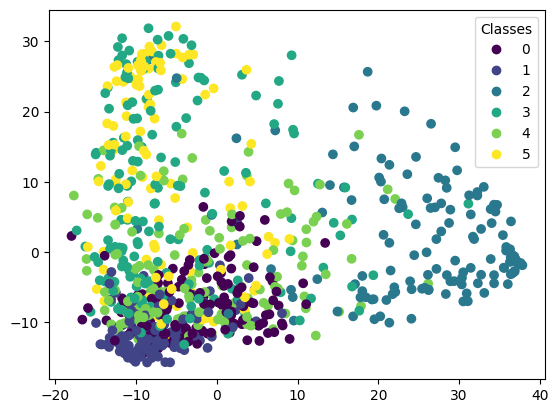

In [53]:
# Run PCA on latent
braincapture_annotations = {'Eye blinking': 0, 'Eye movement left-right': 1, 'Eyes closed': 2, 'Eyes opened': 3, 'Jaw clenching': 4, 'Hyperventilation': 5}

pca = PCA(n_components=30)
pca = pca.fit(latent)
latent_pca = pca.transform(latent)

fig, ax = plt.subplots()
plot = ax.scatter(latent_pca[:, 0], latent_pca[:, 1], c = y_BC)
# Legend according to color c = y_BC
ax.legend(*plot.legend_elements(), title="Classes")


plt.show()